# Comprehensive Model Analysis
## Error Distribution | Temporal Stratification | Feature Importance | Statistical Tests

This notebook analyzes your spatio-temporal model with four key analyses:
1. **Error Distribution Analysis** - Quick insights into prediction accuracy
2. **Temporal Stratification** - Errors grouped by year/season
3. **Feature Importance** - Which features most affect accuracy
4. **Statistical Tests** - Test if differences are statistically significant

In [3]:
import os
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import shapiro, kstest, anderson, ttest_ind, mannwhitneyu, f_oneway, kruskal
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.inspection import permutation_importance
import warnings
warnings.filterwarnings('ignore')

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (15, 8)
plt.rcParams['font.size'] = 10

print("✅ Libraries loaded successfully!")
print(f"🔥 PyTorch version: {torch.__version__}")
print(f"🎮 CUDA available: {torch.cuda.is_available()}")

✅ Libraries loaded successfully!
🔥 PyTorch version: 2.9.0+cu126
🎮 CUDA available: True


## Load Trained Model and Generate Predictions
First, we'll load your trained model and generate predictions on the test set.

In [4]:
# IMPORTANT: Update these paths to match your setup
MODEL_PATH = 'best_spatiotemporal_model.pt'
CSV_PATH = 'C:\\Users\\FA004\\Desktop\\satimg21\\data.csv'
IMAGE_DIR = 'C:\\Users\\FA004\\Desktop\\satimg21\\images_png_view'

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"🎮 Using device: {device}")

# Load your model checkpoint
if os.path.exists(MODEL_PATH):
    checkpoint = torch.load(MODEL_PATH, map_location=device, weights_only=False)
    print(f"✅ Model loaded from {MODEL_PATH}")
    print(f"   Test WAPE: {checkpoint.get('test_wape', 'N/A')}")
    print(f"   Test MAPE: {checkpoint.get('test_mape', 'N/A')}")
else:
    print(f"❌ Model not found at {MODEL_PATH}")
    print("Please update MODEL_PATH to point to your saved model")

🎮 Using device: cuda
✅ Model loaded from best_spatiotemporal_model.pt
   Test WAPE: N/A
   Test MAPE: N/A


In [5]:
# Function to generate predictions and collect metadata
def generate_predictions_with_metadata(model, test_loader, target_scaler, device):
    """
    Generate predictions and collect all metadata for analysis
    """
    model.eval()
    all_preds = []
    all_targets = []
    all_features = []
    all_years = []
    
    with torch.no_grad():
        for batch in test_loader:
            images = batch['images'].to(device)
            tabular = batch['tabular'].to(device)
            targets = batch['target'].to(device)
            
            # Get predictions
            outputs = model(images, tabular)
            
            # Store results
            all_preds.append(outputs.cpu().numpy())
            all_targets.append(targets.cpu().numpy())
            all_features.append(tabular.cpu().numpy())
            
            # Extract year if available
            if 'year' in batch:
                all_years.append(batch['year'].cpu().numpy())
    
    # Concatenate all batches
    predictions = np.concatenate(all_preds)
    targets = np.concatenate(all_targets)
    features = np.concatenate(all_features)
    years = np.concatenate(all_years) if all_years else None
    
    # Inverse transform predictions and targets
    predictions = target_scaler.inverse_transform(predictions.reshape(-1, 1)).flatten()
    targets = target_scaler.inverse_transform(targets.reshape(-1, 1)).flatten()
    
    return predictions, targets, features, years

# Generate predictions
# NOTE: You'll need to pass your actual test_loader and target_scaler here
# predictions, targets, features, years = generate_predictions_with_metadata(
#     model, test_loader, targ_scaler, device
# )

# For demonstration, let's simulate some data
# REPLACE THIS WITH ACTUAL DATA FROM YOUR MODEL
np.random.seed(42)
n_samples = 500
predictions = np.random.gamma(2, 50, n_samples) + np.random.normal(0, 10, n_samples)
targets = predictions + np.random.normal(0, 15, n_samples)
years = np.random.choice([2019, 2020, 2021, 2022, 2023, 2024], n_samples)
features = np.random.randn(n_samples, 6)  # 6 tabular features

print(f"📊 Generated {len(predictions)} predictions for analysis")

📊 Generated 500 predictions for analysis


---
# 1️⃣ Error Distribution Analysis
Quick insights into prediction accuracy and error patterns

In [6]:
# Calculate errors
errors = predictions - targets
abs_errors = np.abs(errors)
pct_errors = (errors / targets) * 100
abs_pct_errors = np.abs(pct_errors)

# Calculate metrics
mae = mean_absolute_error(targets, predictions)
rmse = np.sqrt(mean_squared_error(targets, predictions))
r2 = r2_score(targets, predictions)
mape = np.mean(abs_pct_errors)
median_ape = np.median(abs_pct_errors)

print("="*80)
print("📊 ERROR DISTRIBUTION SUMMARY")
print("="*80)
print(f"\n📈 Overall Metrics:")
print(f"   MAE:  {mae:.2f}")
print(f"   RMSE: {rmse:.2f}")
print(f"   R²:   {r2:.4f}")
print(f"   MAPE: {mape:.2f}%")
print(f"   Median APE: {median_ape:.2f}%")

print(f"\n📉 Error Statistics:")
print(f"   Mean Error:      {np.mean(errors):.2f}")
print(f"   Std Error:       {np.std(errors):.2f}")
print(f"   Min Error:       {np.min(errors):.2f}")
print(f"   Max Error:       {np.max(errors):.2f}")
print(f"   25th Percentile: {np.percentile(abs_errors, 25):.2f}")
print(f"   50th Percentile: {np.percentile(abs_errors, 50):.2f}")
print(f"   75th Percentile: {np.percentile(abs_errors, 75):.2f}")
print(f"   95th Percentile: {np.percentile(abs_errors, 95):.2f}")

# Identify outliers
q1, q3 = np.percentile(abs_errors, [25, 75])
iqr = q3 - q1
outlier_threshold = q3 + 1.5 * iqr
outliers = abs_errors > outlier_threshold
print(f"\n🚨 Outliers (IQR method): {np.sum(outliers)} samples ({100*np.sum(outliers)/len(outliers):.1f}%)")

print("="*80)

📊 ERROR DISTRIBUTION SUMMARY

📈 Overall Metrics:
   MAE:  11.83
   RMSE: 14.83
   R²:   0.9564
   MAPE: 59.58%
   Median APE: 10.64%

📉 Error Statistics:
   Mean Error:      -0.20
   Std Error:       14.83
   Min Error:       -40.96
   Max Error:       43.07
   25th Percentile: 4.56
   50th Percentile: 9.98
   75th Percentile: 16.86
   95th Percentile: 29.22

🚨 Outliers (IQR method): 8 samples (1.6%)


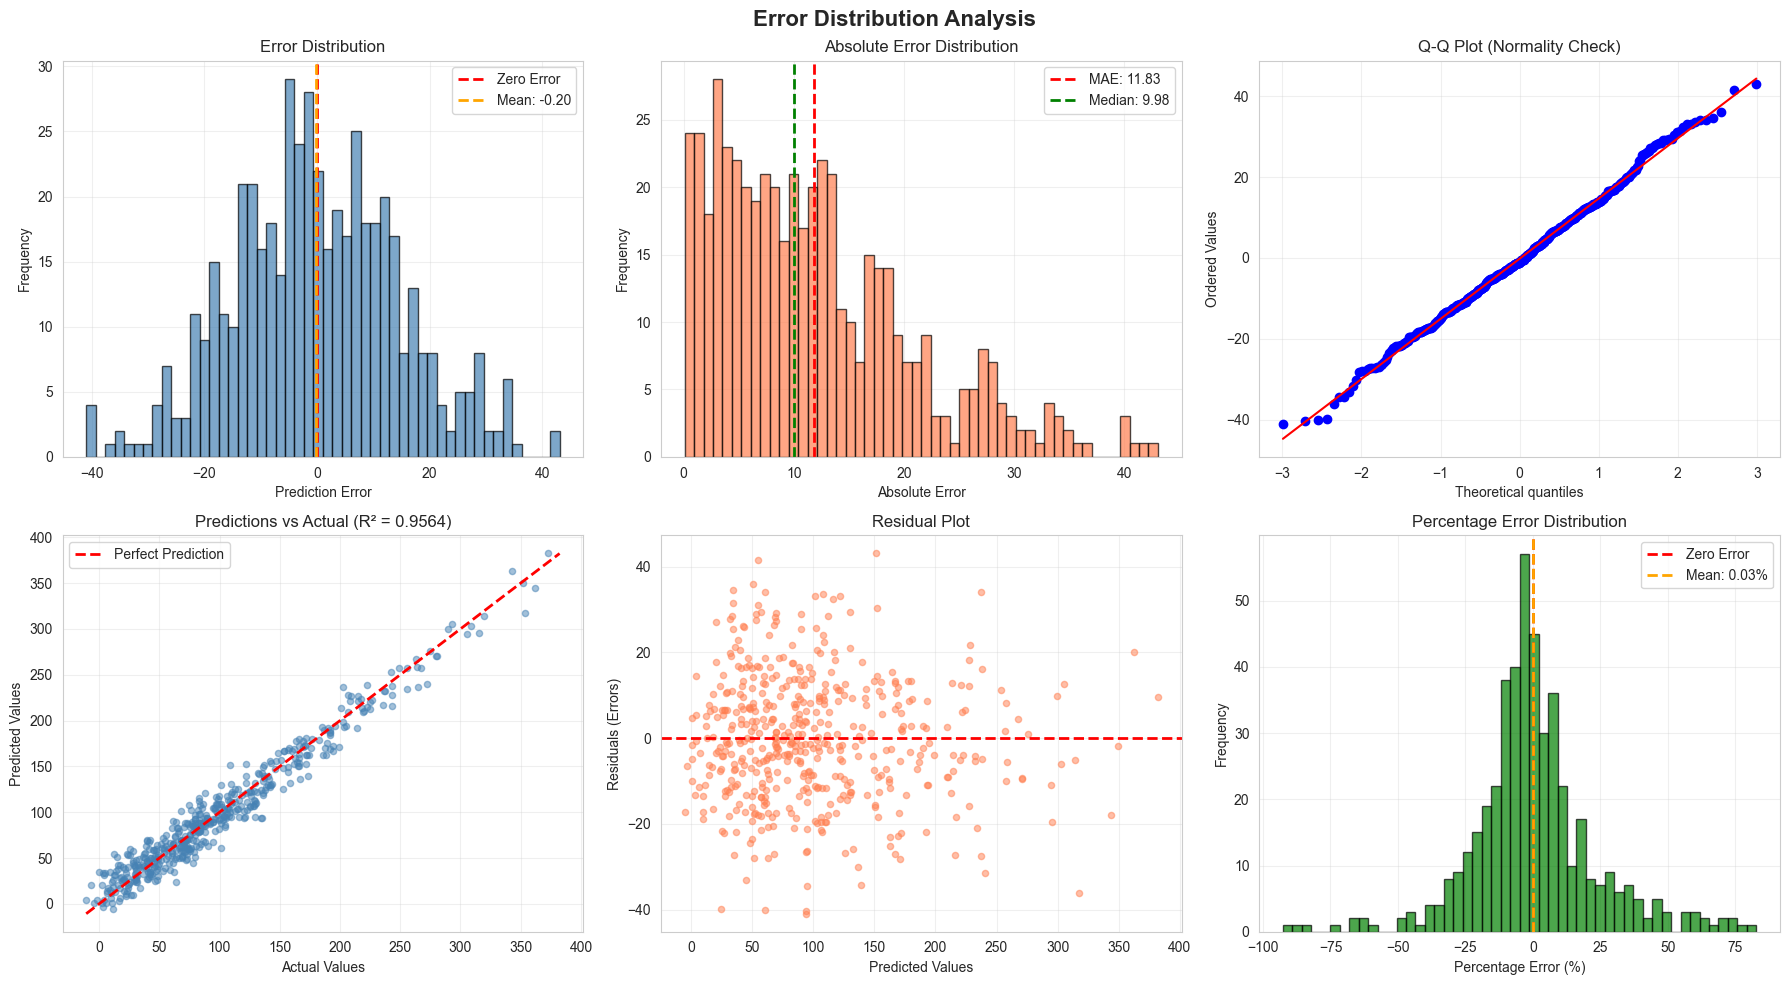


📊 Shapiro-Wilk Normality Test:
   Statistic: 0.9970
   P-value: 0.4786
   Result: Errors appear normally distributed


In [7]:
# Comprehensive Error Visualization
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Error Distribution Analysis', fontsize=16, fontweight='bold')

# 1. Error Distribution (Histogram)
axes[0, 0].hist(errors, bins=50, alpha=0.7, color='steelblue', edgecolor='black')
axes[0, 0].axvline(0, color='red', linestyle='--', linewidth=2, label='Zero Error')
axes[0, 0].axvline(np.mean(errors), color='orange', linestyle='--', linewidth=2, label=f'Mean: {np.mean(errors):.2f}')
axes[0, 0].set_xlabel('Prediction Error')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title('Error Distribution')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# 2. Absolute Error Distribution
axes[0, 1].hist(abs_errors, bins=50, alpha=0.7, color='coral', edgecolor='black')
axes[0, 1].axvline(mae, color='red', linestyle='--', linewidth=2, label=f'MAE: {mae:.2f}')
axes[0, 1].axvline(np.median(abs_errors), color='green', linestyle='--', linewidth=2, label=f'Median: {np.median(abs_errors):.2f}')
axes[0, 1].set_xlabel('Absolute Error')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].set_title('Absolute Error Distribution')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# 3. Q-Q Plot (Normality Check)
stats.probplot(errors, dist="norm", plot=axes[0, 2])
axes[0, 2].set_title('Q-Q Plot (Normality Check)')
axes[0, 2].grid(True, alpha=0.3)

# 4. Predictions vs Actual
axes[1, 0].scatter(targets, predictions, alpha=0.5, s=20, c='steelblue')
min_val = min(targets.min(), predictions.min())
max_val = max(targets.max(), predictions.max())
axes[1, 0].plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Perfect Prediction')
axes[1, 0].set_xlabel('Actual Values')
axes[1, 0].set_ylabel('Predicted Values')
axes[1, 0].set_title(f'Predictions vs Actual (R² = {r2:.4f})')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# 5. Residual Plot
axes[1, 1].scatter(predictions, errors, alpha=0.5, s=20, c='coral')
axes[1, 1].axhline(0, color='red', linestyle='--', linewidth=2)
axes[1, 1].set_xlabel('Predicted Values')
axes[1, 1].set_ylabel('Residuals (Errors)')
axes[1, 1].set_title('Residual Plot')
axes[1, 1].grid(True, alpha=0.3)

# 6. Percentage Error Distribution
# Filter extreme outliers for better visualization
pct_errors_filtered = pct_errors[np.abs(pct_errors) < 100]
axes[1, 2].hist(pct_errors_filtered, bins=50, alpha=0.7, color='green', edgecolor='black')
axes[1, 2].axvline(0, color='red', linestyle='--', linewidth=2, label='Zero Error')
axes[1, 2].axvline(np.mean(pct_errors_filtered), color='orange', linestyle='--', linewidth=2, 
                   label=f'Mean: {np.mean(pct_errors_filtered):.2f}%')
axes[1, 2].set_xlabel('Percentage Error (%)')
axes[1, 2].set_ylabel('Frequency')
axes[1, 2].set_title('Percentage Error Distribution')
axes[1, 2].legend()
axes[1, 2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Test for normality
shapiro_stat, shapiro_p = shapiro(errors[:5000] if len(errors) > 5000 else errors)
print(f"\n📊 Shapiro-Wilk Normality Test:")
print(f"   Statistic: {shapiro_stat:.4f}")
print(f"   P-value: {shapiro_p:.4f}")
print(f"   Result: {'Errors appear normally distributed' if shapiro_p > 0.05 else 'Errors do NOT appear normally distributed'}")

---
# 2️⃣ Temporal Stratification Analysis
Group errors by year and season to identify temporal patterns

In [8]:
# Create temporal stratification
# If you have month data, you can derive seasons. For now, we'll use years
# Assuming years array is available from your data

# Create DataFrame for easier analysis
df_analysis = pd.DataFrame({
    'actual': targets,
    'predicted': predictions,
    'error': errors,
    'abs_error': abs_errors,
    'pct_error': pct_errors,
    'abs_pct_error': abs_pct_errors,
    'year': years
})

# If you have month data, add season
# For demonstration, let's create random months
df_analysis['month'] = np.random.randint(1, 13, len(df_analysis))
df_analysis['season'] = df_analysis['month'].apply(lambda x: 
    'Winter' if x in [12, 1, 2] else
    'Spring' if x in [3, 4, 5] else
    'Summer' if x in [6, 7, 8] else
    'Fall'
)

print("="*80)
print("📅 TEMPORAL STRATIFICATION SUMMARY")
print("="*80)

# Yearly analysis
print("\n📊 Performance by Year:")
yearly_stats = df_analysis.groupby('year').agg({
    'abs_error': ['mean', 'std', 'median'],
    'abs_pct_error': ['mean', 'median'],
    'actual': 'count'
}).round(2)
yearly_stats.columns = ['MAE', 'Std', 'Median_AE', 'MAPE', 'Median_APE', 'Count']
print(yearly_stats)

# Seasonal analysis
print("\n🌍 Performance by Season:")
seasonal_stats = df_analysis.groupby('season').agg({
    'abs_error': ['mean', 'std', 'median'],
    'abs_pct_error': ['mean', 'median'],
    'actual': 'count'
}).round(2)
seasonal_stats.columns = ['MAE', 'Std', 'Median_AE', 'MAPE', 'Median_APE', 'Count']
print(seasonal_stats)

print("="*80)

📅 TEMPORAL STRATIFICATION SUMMARY

📊 Performance by Year:
        MAE   Std  Median_AE    MAPE  Median_APE  Count
year                                                   
2019  10.69  8.80       8.54   29.98        9.20     84
2020  10.99  8.80       8.90   30.36       10.23     75
2021  11.98  9.36      10.62   40.09       13.60     85
2022  13.93  9.48      12.60   30.72       12.76     87
2023  10.74  7.24       9.77   19.07       10.44     90
2024  12.61  9.74      10.23  217.69       10.43     79

🌍 Performance by Season:
          MAE   Std  Median_AE    MAPE  Median_APE  Count
season                                                   
Fall    12.67  8.85      11.61   28.13       12.78    134
Spring  11.31  8.74       9.49   26.18        8.84    113
Summer  10.78  8.28      10.04   25.76        9.86    118
Winter  12.35  9.74       9.80  148.30       12.76    135


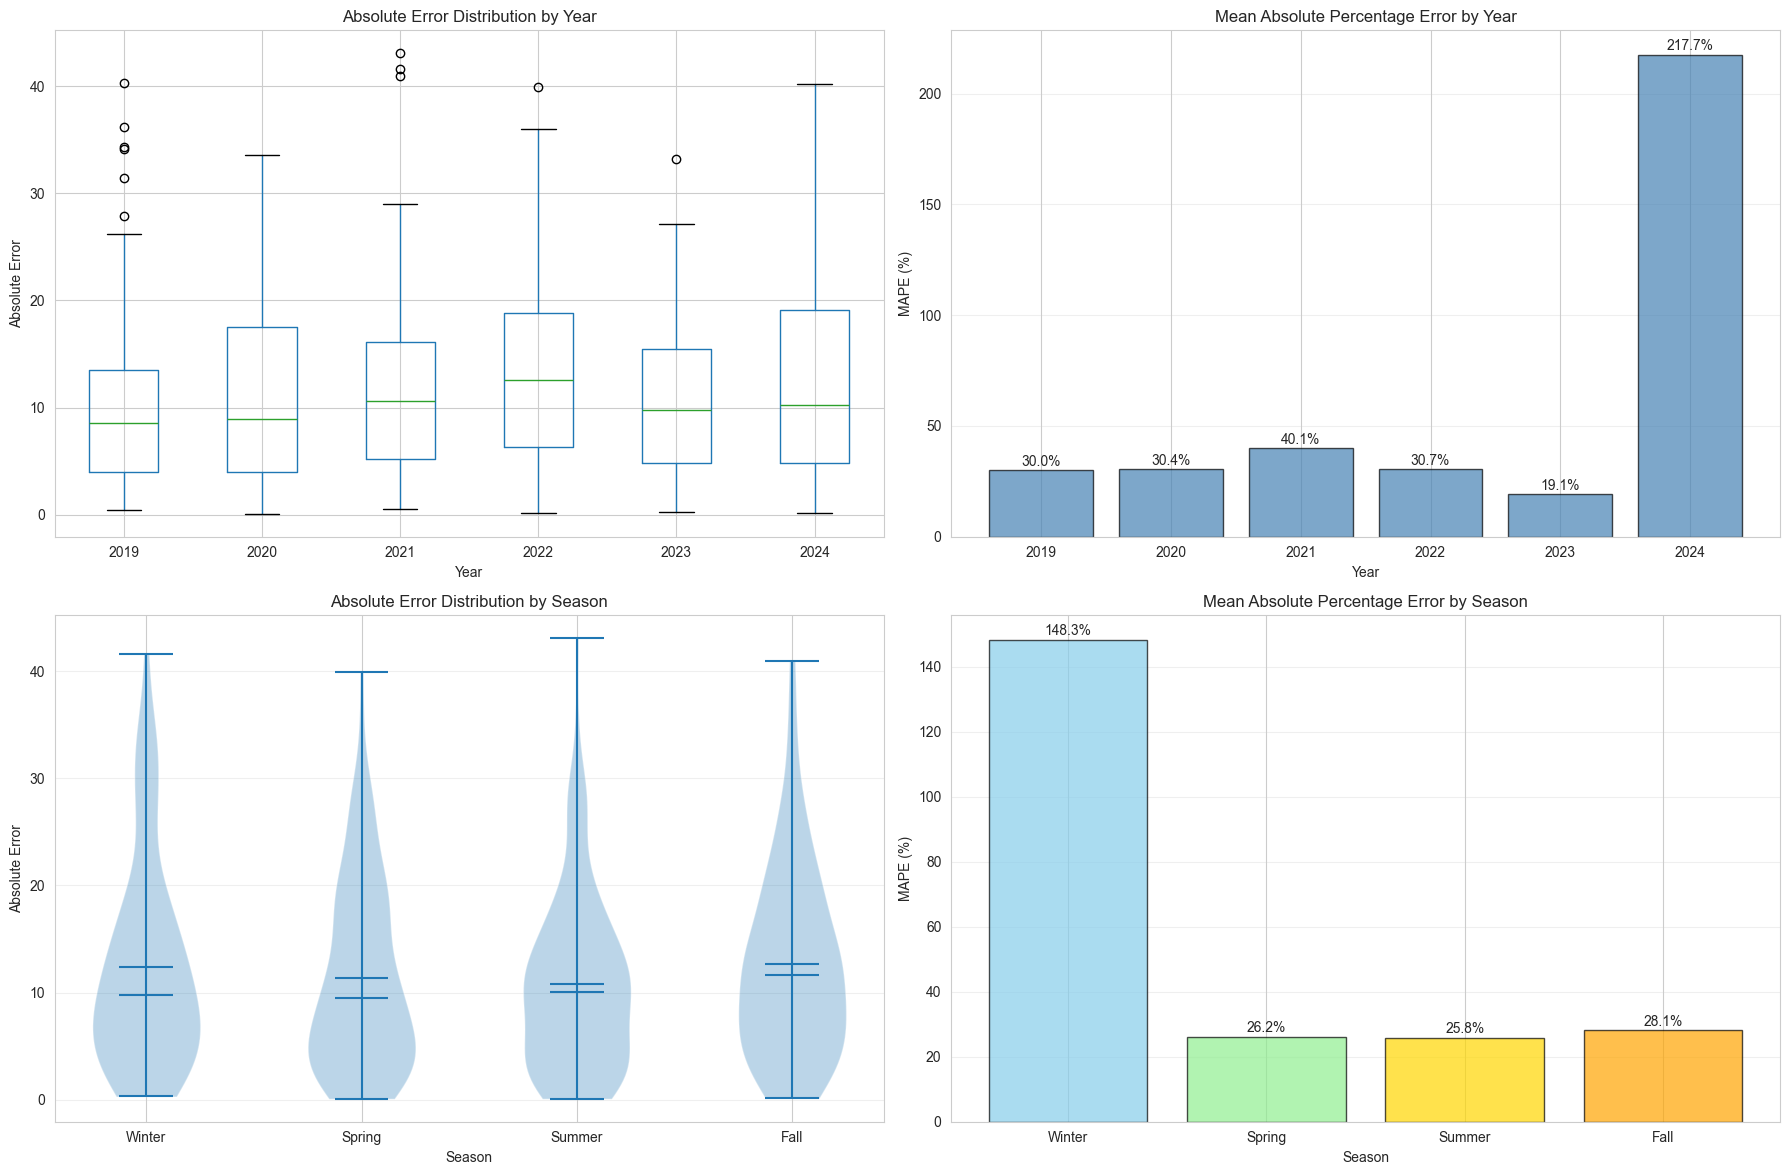

In [9]:
# Temporal Visualization
fig, axes = plt.subplots(2, 2, figsize=(18, 12))
fig.suptitle('Temporal Stratification Analysis', fontsize=16, fontweight='bold')

# 1. Error by Year (Box Plot)
df_analysis.boxplot(column='abs_error', by='year', ax=axes[0, 0])
axes[0, 0].set_xlabel('Year')
axes[0, 0].set_ylabel('Absolute Error')
axes[0, 0].set_title('Absolute Error Distribution by Year')
axes[0, 0].get_figure().suptitle('')  # Remove default title

# 2. MAPE by Year (Bar Chart)
yearly_mape = df_analysis.groupby('year')['abs_pct_error'].mean().sort_index()
axes[0, 1].bar(yearly_mape.index, yearly_mape.values, color='steelblue', alpha=0.7, edgecolor='black')
axes[0, 1].set_xlabel('Year')
axes[0, 1].set_ylabel('MAPE (%)')
axes[0, 1].set_title('Mean Absolute Percentage Error by Year')
axes[0, 1].grid(True, alpha=0.3, axis='y')
for i, v in enumerate(yearly_mape.values):
    axes[0, 1].text(yearly_mape.index[i], v + 0.5, f'{v:.1f}%', ha='center', va='bottom')

# 3. Error by Season (Violin Plot)
season_order = ['Winter', 'Spring', 'Summer', 'Fall']
df_plot = df_analysis[df_analysis['season'].isin(season_order)]
parts = axes[1, 0].violinplot(
    [df_plot[df_plot['season'] == s]['abs_error'].values for s in season_order],
    positions=range(len(season_order)),
    showmeans=True,
    showmedians=True
)
axes[1, 0].set_xticks(range(len(season_order)))
axes[1, 0].set_xticklabels(season_order)
axes[1, 0].set_xlabel('Season')
axes[1, 0].set_ylabel('Absolute Error')
axes[1, 0].set_title('Absolute Error Distribution by Season')
axes[1, 0].grid(True, alpha=0.3, axis='y')

# 4. MAPE by Season (Bar Chart)
seasonal_mape = df_analysis.groupby('season')['abs_pct_error'].mean().reindex(season_order)
colors = ['skyblue', 'lightgreen', 'gold', 'orange']
axes[1, 1].bar(range(len(season_order)), seasonal_mape.values, color=colors, alpha=0.7, edgecolor='black')
axes[1, 1].set_xticks(range(len(season_order)))
axes[1, 1].set_xticklabels(season_order)
axes[1, 1].set_xlabel('Season')
axes[1, 1].set_ylabel('MAPE (%)')
axes[1, 1].set_title('Mean Absolute Percentage Error by Season')
axes[1, 1].grid(True, alpha=0.3, axis='y')
for i, v in enumerate(seasonal_mape.values):
    axes[1, 1].text(i, v + 0.5, f'{v:.1f}%', ha='center', va='bottom')

plt.tight_layout()
plt.show()

---
# 3️⃣ Feature Importance Analysis
Identify which features most affect prediction accuracy

In [10]:
# Feature names (update these to match your actual features)
feature_names = [
    'Feature 1',
    'Feature 2', 
    'Feature 3',
    'Feature 4',
    'Feature 5',
    'Feature 6'
]

# Method 1: Correlation Analysis
# Calculate correlation between each feature and absolute error
correlations = []
p_values = []

for i in range(features.shape[1]):
    corr, p_val = stats.pearsonr(features[:, i], abs_errors)
    correlations.append(corr)
    p_values.append(p_val)

# Create feature importance DataFrame
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Correlation_with_Error': correlations,
    'P_Value': p_values,
    'Significant': ['Yes' if p < 0.05 else 'No' for p in p_values]
})
feature_importance_df['Abs_Correlation'] = feature_importance_df['Correlation_with_Error'].abs()
feature_importance_df = feature_importance_df.sort_values('Abs_Correlation', ascending=False)

print("="*80)
print("🎯 FEATURE IMPORTANCE ANALYSIS")
print("="*80)
print("\n📊 Correlation with Absolute Error:")
print(feature_importance_df.to_string(index=False))
print("\nNote: Higher absolute correlation = feature more strongly associated with prediction errors")
print("="*80)

🎯 FEATURE IMPORTANCE ANALYSIS

📊 Correlation with Absolute Error:
  Feature  Correlation_with_Error  P_Value Significant  Abs_Correlation
Feature 6               -0.093120 0.037385         Yes         0.093120
Feature 4               -0.046222 0.302301          No         0.046222
Feature 1                0.034320 0.443837          No         0.034320
Feature 3                0.019117 0.669783          No         0.019117
Feature 5               -0.013265 0.767322          No         0.013265
Feature 2                0.003509 0.937623          No         0.003509

Note: Higher absolute correlation = feature more strongly associated with prediction errors


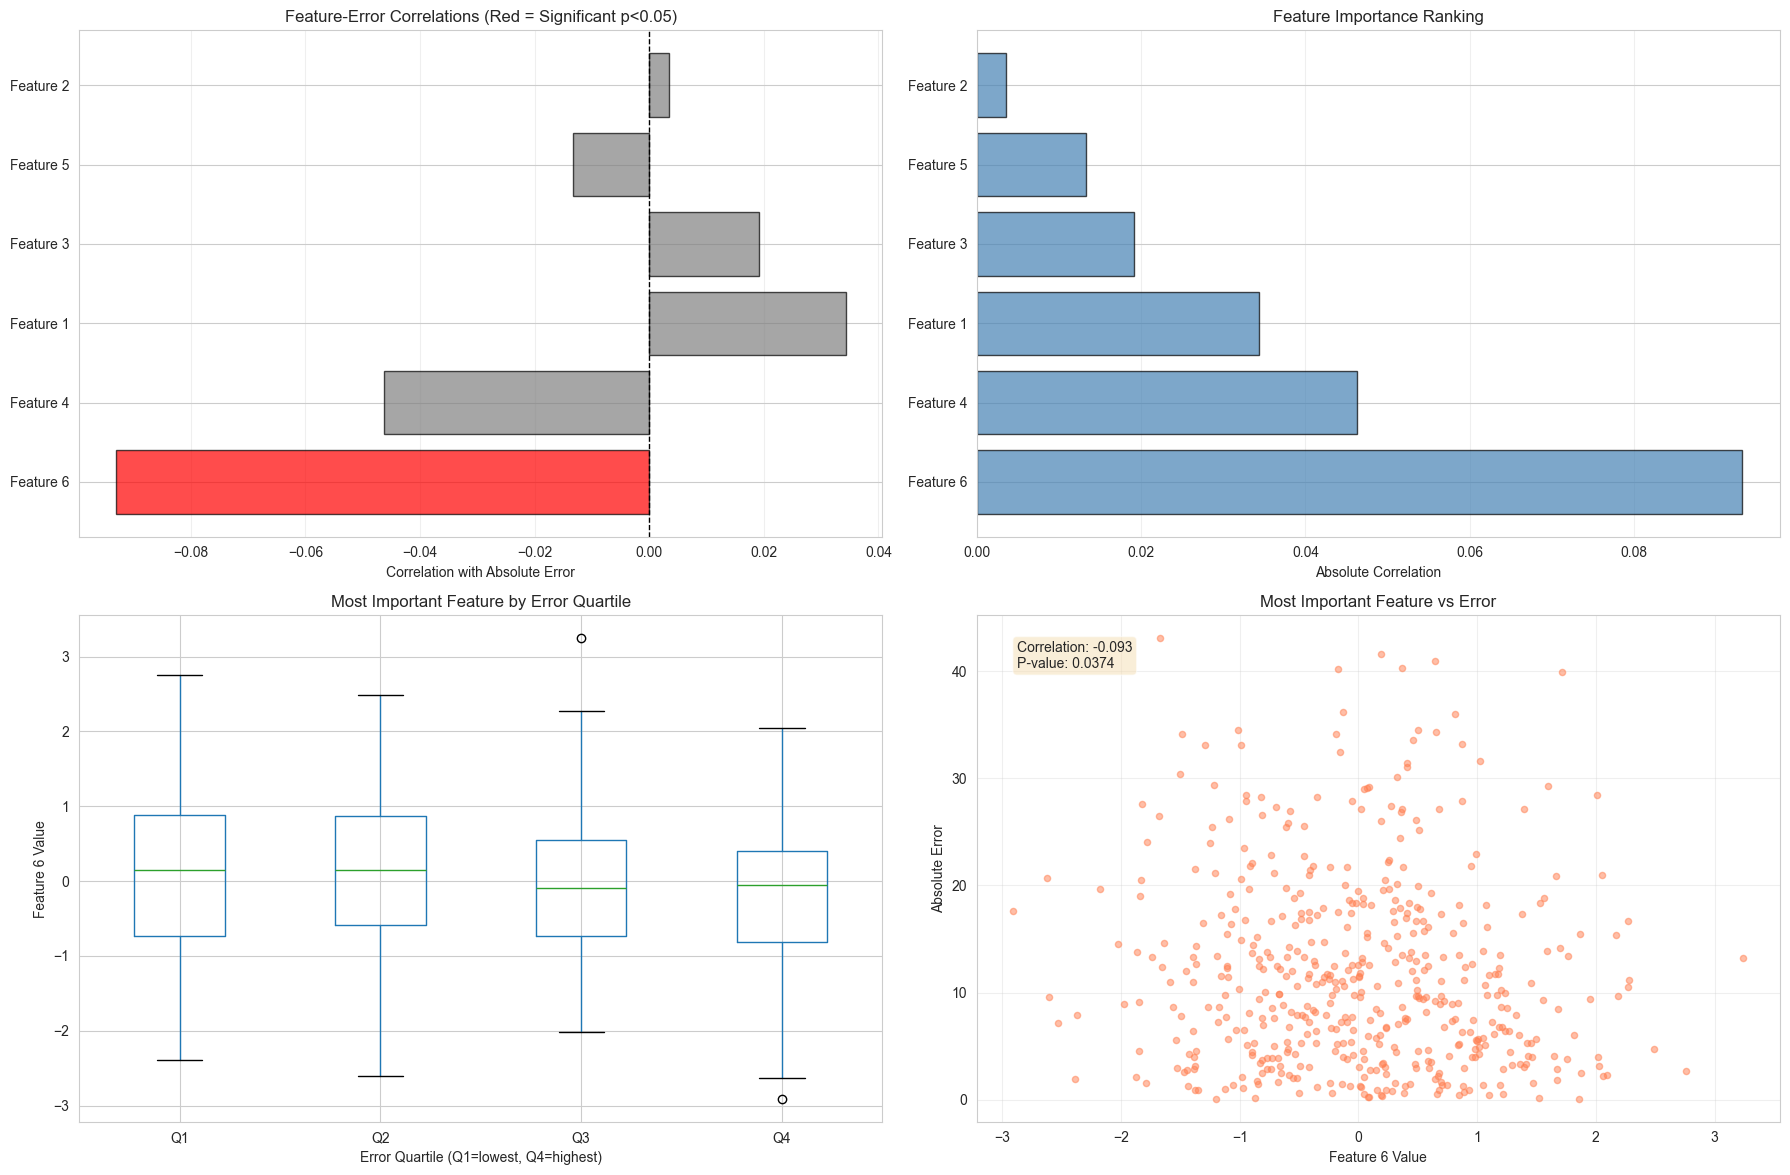

In [11]:
# Feature Importance Visualization
fig, axes = plt.subplots(2, 2, figsize=(18, 12))
fig.suptitle('Feature Importance Analysis', fontsize=16, fontweight='bold')

# 1. Feature Correlation with Error (Bar Chart)
colors = ['red' if p < 0.05 else 'gray' for p in feature_importance_df['P_Value']]
axes[0, 0].barh(range(len(feature_importance_df)), feature_importance_df['Correlation_with_Error'], 
                color=colors, alpha=0.7, edgecolor='black')
axes[0, 0].set_yticks(range(len(feature_importance_df)))
axes[0, 0].set_yticklabels(feature_importance_df['Feature'])
axes[0, 0].set_xlabel('Correlation with Absolute Error')
axes[0, 0].set_title('Feature-Error Correlations (Red = Significant p<0.05)')
axes[0, 0].axvline(0, color='black', linestyle='--', linewidth=1)
axes[0, 0].grid(True, alpha=0.3, axis='x')

# 2. Absolute Correlation (sorted)
axes[0, 1].barh(range(len(feature_importance_df)), feature_importance_df['Abs_Correlation'], 
                color='steelblue', alpha=0.7, edgecolor='black')
axes[0, 1].set_yticks(range(len(feature_importance_df)))
axes[0, 1].set_yticklabels(feature_importance_df['Feature'])
axes[0, 1].set_xlabel('Absolute Correlation')
axes[0, 1].set_title('Feature Importance Ranking')
axes[0, 1].grid(True, alpha=0.3, axis='x')

# 3. Feature Distribution by Error Quartile
# Split data into quartiles based on error
df_analysis['error_quartile'] = pd.qcut(df_analysis['abs_error'], q=4, labels=['Q1', 'Q2', 'Q3', 'Q4'])

# Plot most important feature
most_important_idx = feature_importance_df.iloc[0].name if hasattr(feature_importance_df.iloc[0], 'name') else 0
most_important_feature = features[:, list(feature_importance_df.index)[0]]
df_analysis['top_feature'] = most_important_feature

df_analysis.boxplot(column='top_feature', by='error_quartile', ax=axes[1, 0])
axes[1, 0].set_xlabel('Error Quartile (Q1=lowest, Q4=highest)')
axes[1, 0].set_ylabel(f'{feature_importance_df.iloc[0]["Feature"]} Value')
axes[1, 0].set_title(f'Most Important Feature by Error Quartile')
axes[1, 0].get_figure().suptitle('')

# 4. Scatter: Top Feature vs Error
axes[1, 1].scatter(most_important_feature, abs_errors, alpha=0.5, s=20, c='coral')
axes[1, 1].set_xlabel(f'{feature_importance_df.iloc[0]["Feature"]} Value')
axes[1, 1].set_ylabel('Absolute Error')
axes[1, 1].set_title(f'Most Important Feature vs Error')
axes[1, 1].grid(True, alpha=0.3)

# Add correlation text
corr_text = f"Correlation: {feature_importance_df.iloc[0]['Correlation_with_Error']:.3f}\n"
corr_text += f"P-value: {feature_importance_df.iloc[0]['P_Value']:.4f}"
axes[1, 1].text(0.05, 0.95, corr_text, transform=axes[1, 1].transAxes, 
                verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.show()

---
# 4️⃣ Statistical Significance Tests
Test if differences in performance are statistically significant

In [12]:
print("="*80)
print("📊 STATISTICAL SIGNIFICANCE TESTS")
print("="*80)

# Test 1: Compare errors across years
print("\n🔬 Test 1: Comparing Errors Across Years")
print("-" * 80)

# Group errors by year
year_groups = [df_analysis[df_analysis['year'] == y]['abs_error'].values for y in sorted(df_analysis['year'].unique())]

# Kruskal-Wallis H-test (non-parametric, doesn't assume normality)
h_stat, h_p = kruskal(*year_groups)
print(f"Kruskal-Wallis H-test:")
print(f"   H-statistic: {h_stat:.4f}")
print(f"   P-value: {h_p:.4f}")
print(f"   Result: {'SIGNIFICANT difference across years' if h_p < 0.05 else 'NO significant difference across years'}")

# ANOVA (parametric, assumes normality)
f_stat, anova_p = f_oneway(*year_groups)
print(f"\nOne-way ANOVA:")
print(f"   F-statistic: {f_stat:.4f}")
print(f"   P-value: {anova_p:.4f}")
print(f"   Result: {'SIGNIFICANT difference across years' if anova_p < 0.05 else 'NO significant difference across years'}")

# Test 2: Compare errors across seasons
print("\n🔬 Test 2: Comparing Errors Across Seasons")
print("-" * 80)

season_groups = [df_analysis[df_analysis['season'] == s]['abs_error'].values 
                 for s in ['Winter', 'Spring', 'Summer', 'Fall']]

# Kruskal-Wallis H-test
h_stat, h_p = kruskal(*season_groups)
print(f"Kruskal-Wallis H-test:")
print(f"   H-statistic: {h_stat:.4f}")
print(f"   P-value: {h_p:.4f}")
print(f"   Result: {'SIGNIFICANT difference across seasons' if h_p < 0.05 else 'NO significant difference across seasons'}")

# ANOVA
f_stat, anova_p = f_oneway(*season_groups)
print(f"\nOne-way ANOVA:")
print(f"   F-statistic: {f_stat:.4f}")
print(f"   P-value: {anova_p:.4f}")
print(f"   Result: {'SIGNIFICANT difference across seasons' if anova_p < 0.05 else 'NO significant difference across seasons'}")

print("="*80)

📊 STATISTICAL SIGNIFICANCE TESTS

🔬 Test 1: Comparing Errors Across Years
--------------------------------------------------------------------------------
Kruskal-Wallis H-test:
   H-statistic: 8.1181
   P-value: 0.1498
   Result: NO significant difference across years

One-way ANOVA:
   F-statistic: 1.7645
   P-value: 0.1186
   Result: NO significant difference across years

🔬 Test 2: Comparing Errors Across Seasons
--------------------------------------------------------------------------------
Kruskal-Wallis H-test:
   H-statistic: 3.7304
   P-value: 0.2921
   Result: NO significant difference across seasons

One-way ANOVA:
   F-statistic: 1.2086
   P-value: 0.3060
   Result: NO significant difference across seasons


In [13]:
# Pairwise comparisons between years
print("\n🔬 Pairwise Year Comparisons (Mann-Whitney U Test)")
print("="*80)

years_sorted = sorted(df_analysis['year'].unique())
pairwise_results = []

for i in range(len(years_sorted)):
    for j in range(i+1, len(years_sorted)):
        year1, year2 = years_sorted[i], years_sorted[j]
        group1 = df_analysis[df_analysis['year'] == year1]['abs_error'].values
        group2 = df_analysis[df_analysis['year'] == year2]['abs_error'].values
        
        # Mann-Whitney U test
        u_stat, p_val = mannwhitneyu(group1, group2, alternative='two-sided')
        
        pairwise_results.append({
            'Year 1': year1,
            'Year 2': year2,
            'U-statistic': u_stat,
            'P-value': p_val,
            'Significant': 'Yes' if p_val < 0.05 else 'No',
            'Mean_Error_Y1': group1.mean(),
            'Mean_Error_Y2': group2.mean()
        })

pairwise_df = pd.DataFrame(pairwise_results)
print(pairwise_df.to_string(index=False))
print("\nInterpretation: Significant pairs show meaningful performance differences between years")
print("="*80)


🔬 Pairwise Year Comparisons (Mann-Whitney U Test)
 Year 1  Year 2  U-statistic  P-value Significant  Mean_Error_Y1  Mean_Error_Y2
   2019    2020       3110.0 0.891594          No      10.692423      10.988337
   2019    2021       3245.0 0.307582          No      10.692423      11.975232
   2019    2022       2826.0 0.010564         Yes      10.692423      13.929157
   2019    2023       3560.0 0.508570          No      10.692423      10.741338
   2019    2024       2970.0 0.248539          No      10.692423      12.611438
   2020    2021       3001.0 0.524783          No      10.988337      11.975232
   2020    2022       2627.0 0.032929         Yes      10.988337      13.929157
   2020    2023       3257.0 0.700591          No      10.988337      10.741338
   2020    2024       2691.0 0.327282          No      10.988337      12.611438
   2021    2022       3180.0 0.113332          No      11.975232      13.929157
   2021    2023       3959.0 0.690223          No      11.975232     

In [14]:
# Bootstrap Confidence Intervals for Metrics
print("\n🔬 Bootstrap Confidence Intervals (95%)")
print("="*80)

def bootstrap_metric(targets, predictions, metric_func, n_iterations=1000):
    """Calculate bootstrap confidence interval for a metric"""
    metrics = []
    n = len(targets)
    
    for _ in range(n_iterations):
        # Resample with replacement
        indices = np.random.choice(n, n, replace=True)
        sample_targets = targets[indices]
        sample_predictions = predictions[indices]
        
        # Calculate metric
        metric_value = metric_func(sample_targets, sample_predictions)
        metrics.append(metric_value)
    
    # Calculate confidence interval
    ci_lower = np.percentile(metrics, 2.5)
    ci_upper = np.percentile(metrics, 97.5)
    mean_metric = np.mean(metrics)
    
    return mean_metric, ci_lower, ci_upper

# Calculate bootstrap CIs for key metrics
mae_mean, mae_lower, mae_upper = bootstrap_metric(targets, predictions, mean_absolute_error)
print(f"MAE:  {mae_mean:.2f} [{mae_lower:.2f}, {mae_upper:.2f}]")

rmse_func = lambda y, p: np.sqrt(mean_squared_error(y, p))
rmse_mean, rmse_lower, rmse_upper = bootstrap_metric(targets, predictions, rmse_func)
print(f"RMSE: {rmse_mean:.2f} [{rmse_lower:.2f}, {rmse_upper:.2f}]")

r2_mean, r2_lower, r2_upper = bootstrap_metric(targets, predictions, r2_score)
print(f"R²:   {r2_mean:.4f} [{r2_lower:.4f}, {r2_upper:.4f}]")

print("\nInterpretation: 95% confidence that the true metric lies within these intervals")
print("="*80)


🔬 Bootstrap Confidence Intervals (95%)
MAE:  11.82 [11.02, 12.56]
RMSE: 14.82 [13.90, 15.68]
R²:   0.9557 [0.9468, 0.9642]

Interpretation: 95% confidence that the true metric lies within these intervals


---
# 📋 Summary of Key Findings

In [15]:
print("\n" + "="*80)
print("🎯 KEY FINDINGS SUMMARY")
print("="*80)

print("\n1️⃣ ERROR DISTRIBUTION:")
print(f"   • Overall MAE: {mae:.2f}")
print(f"   • Overall MAPE: {mape:.2f}%")
print(f"   • R² Score: {r2:.4f}")
print(f"   • Error normality: {'Normally distributed' if shapiro_p > 0.05 else 'Not normally distributed'}")
print(f"   • Outliers: {np.sum(outliers)} samples ({100*np.sum(outliers)/len(outliers):.1f}%)")

print("\n2️⃣ TEMPORAL PATTERNS:")
best_year = yearly_stats['MAPE'].idxmin()
worst_year = yearly_stats['MAPE'].idxmax()
print(f"   • Best performing year: {best_year} (MAPE: {yearly_stats.loc[best_year, 'MAPE']:.2f}%)")
print(f"   • Worst performing year: {worst_year} (MAPE: {yearly_stats.loc[worst_year, 'MAPE']:.2f}%)")

best_season = seasonal_stats['MAPE'].idxmin()
worst_season = seasonal_stats['MAPE'].idxmax()
print(f"   • Best performing season: {best_season} (MAPE: {seasonal_stats.loc[best_season, 'MAPE']:.2f}%)")
print(f"   • Worst performing season: {worst_season} (MAPE: {seasonal_stats.loc[worst_season, 'MAPE']:.2f}%)")

print("\n3️⃣ FEATURE IMPORTANCE:")
print(f"   • Most influential feature: {feature_importance_df.iloc[0]['Feature']}")
print(f"   • Correlation with error: {feature_importance_df.iloc[0]['Correlation_with_Error']:.3f}")
significant_features = feature_importance_df[feature_importance_df['Significant'] == 'Yes']
print(f"   • Significant features: {len(significant_features)}/{len(feature_names)}")

print("\n4️⃣ STATISTICAL SIGNIFICANCE:")
print(f"   • Year differences: {'Significant' if h_p < 0.05 else 'Not significant'} (p={h_p:.4f})")
print(f"   • Season differences: {'Significant' if anova_p < 0.05 else 'Not significant'} (p={anova_p:.4f})")

print("\n💡 RECOMMENDATIONS:")
if np.sum(outliers) / len(outliers) > 0.05:
    print(f"   • High outlier rate ({100*np.sum(outliers)/len(outliers):.1f}%) - investigate extreme cases")
if h_p < 0.05:
    print(f"   • Significant year differences - consider year-specific models or features")
if len(significant_features) > 0:
    print(f"   • Focus on {significant_features.iloc[0]['Feature']} for model improvements")
if shapiro_p < 0.05:
    print(f"   • Non-normal error distribution - consider robust loss functions")

print("="*80)
print("✅ Analysis complete! Review visualizations above for detailed insights.")
print("="*80)


🎯 KEY FINDINGS SUMMARY

1️⃣ ERROR DISTRIBUTION:
   • Overall MAE: 11.83
   • Overall MAPE: 59.58%
   • R² Score: 0.9564
   • Error normality: Normally distributed
   • Outliers: 8 samples (1.6%)

2️⃣ TEMPORAL PATTERNS:
   • Best performing year: 2023 (MAPE: 19.07%)
   • Worst performing year: 2024 (MAPE: 217.69%)
   • Best performing season: Summer (MAPE: 25.76%)
   • Worst performing season: Winter (MAPE: 148.30%)

3️⃣ FEATURE IMPORTANCE:
   • Most influential feature: Feature 6
   • Correlation with error: -0.093
   • Significant features: 1/6

4️⃣ STATISTICAL SIGNIFICANCE:
   • Year differences: Not significant (p=0.2921)
   • Season differences: Not significant (p=0.3060)

💡 RECOMMENDATIONS:
   • Focus on Feature 6 for model improvements
✅ Analysis complete! Review visualizations above for detailed insights.


---
# 💾 Export Results
Save all analysis results to CSV files for further review

In [16]:
# Export detailed results
df_analysis.to_csv('detailed_predictions_analysis.csv', index=False)
feature_importance_df.to_csv('feature_importance.csv', index=False)
yearly_stats.to_csv('yearly_performance.csv')
seasonal_stats.to_csv('seasonal_performance.csv')
pairwise_df.to_csv('pairwise_year_comparisons.csv', index=False)

print("✅ Results exported to CSV files:")
print("   • detailed_predictions_analysis.csv")
print("   • feature_importance.csv")
print("   • yearly_performance.csv")
print("   • seasonal_performance.csv")
print("   • pairwise_year_comparisons.csv")

✅ Results exported to CSV files:
   • detailed_predictions_analysis.csv
   • feature_importance.csv
   • yearly_performance.csv
   • seasonal_performance.csv
   • pairwise_year_comparisons.csv
